In [17]:
import os
import cv2
import torch
import numpy as np
import faiss
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def extract_frames(video_path, interval_sec=1):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    count = 0
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if int(count % (fps * interval_sec)) == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(rgb)
        count += 1
    cap.release()
    return frames

def embed_frame(image):
    inputs = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        output = clip_model.get_image_features(**inputs)
    embedding = output / output.norm(p=2, dim=-1, keepdim=True)
    return embedding.cpu().numpy().squeeze()

def load_data(folder_path, max_frames_per_video=200):
    embeddings, labels = [], []
    label_to_name, name_to_label = {}, {}
    label = 0

    for file in os.listdir(folder_path):
        if not file.endswith(".mp4"):
            continue
        game_name = os.path.splitext(file)[0]
        video_path = os.path.join(folder_path, file)
        print(f"Processing: {game_name}")
        frames = extract_frames(video_path)

        for frame in tqdm(frames[:max_frames_per_video], desc=f"{game_name}"):
            emb = embed_frame(frame)
            embeddings.append(emb)
            labels.append(label)

        label_to_name[label] = game_name
        name_to_label[game_name] = label
        label += 1

    return np.array(embeddings), np.array(labels), label_to_name

def build_faiss_index(train_embeddings):
    dim = train_embeddings.shape[1]
    index = faiss.IndexFlatIP(dim)  # cosine similarity (assumes normalized)
    index.add(train_embeddings)
    return index

def faiss_knn_classify(index, train_labels, test_embeddings, k=5):
    preds = []
    for emb in test_embeddings:
        emb = emb.reshape(1, -1)
        D, I = index.search(emb, k)
        nearest_labels = train_labels[I[0]]
        majority_label = np.bincount(nearest_labels).argmax()
        preds.append(majority_label)
    return preds

# === Main Execution ===
if __name__ == "__main__":
    folder = "/Users/raghavsomasundaram/Downloads/IP"  # Change this if needed
    embeddings, labels, label_to_name = load_data(folder)

    # Split into Train/Test
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, stratify=labels, random_state=42)

    # Build FAISS index from training data
    print("Building FAISS index...")
    faiss_index = build_faiss_index(X_train)

    # Predict test data using FAISS + KNN
    print("Predicting with FAISS...")
    y_pred = faiss_knn_classify(faiss_index, y_train, X_test, k=5)

    # Print classification report
    class_names = [label_to_name[i] for i in sorted(label_to_name)]
    print("\n=== Classification Report ===")
    print(classification_report(y_test, y_pred, target_names=class_names))


Processing: NeedForSpeed


NeedForSpeed: 100%|███████████████████████████| 200/200 [00:07<00:00, 25.78it/s]


Processing: MineCraft


MineCraft: 100%|██████████████████████████████| 200/200 [00:07<00:00, 27.14it/s]


Processing: Fortnite


Fortnite: 100%|███████████████████████████████| 200/200 [00:07<00:00, 27.17it/s]


Processing: Fifa23


Fifa23: 100%|█████████████████████████████████| 200/200 [00:07<00:00, 27.43it/s]


Processing: PUBG-PC


PUBG-PC: 100%|████████████████████████████████| 200/200 [00:08<00:00, 23.75it/s]


Processing: Fifa22


Fifa22: 100%|█████████████████████████████████| 200/200 [00:09<00:00, 22.21it/s]

Building FAISS index...
Predicting with FAISS...

=== Classification Report ===
              precision    recall  f1-score   support

NeedForSpeed       1.00      1.00      1.00        40
   MineCraft       1.00      1.00      1.00        40
    Fortnite       1.00      1.00      1.00        40
      Fifa23       0.90      0.90      0.90        40
     PUBG-PC       1.00      1.00      1.00        40
      Fifa22       0.90      0.90      0.90        40

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240




✅ Accuracy: 96.67%

=== Classification Report ===
              precision    recall  f1-score   support

NeedForSpeed       1.00      1.00      1.00        40
   MineCraft       1.00      1.00      1.00        40
    Fortnite       1.00      1.00      1.00        40
      Fifa23       0.90      0.90      0.90        40
     PUBG-PC       1.00      1.00      1.00        40
      Fifa22       0.90      0.90      0.90        40

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



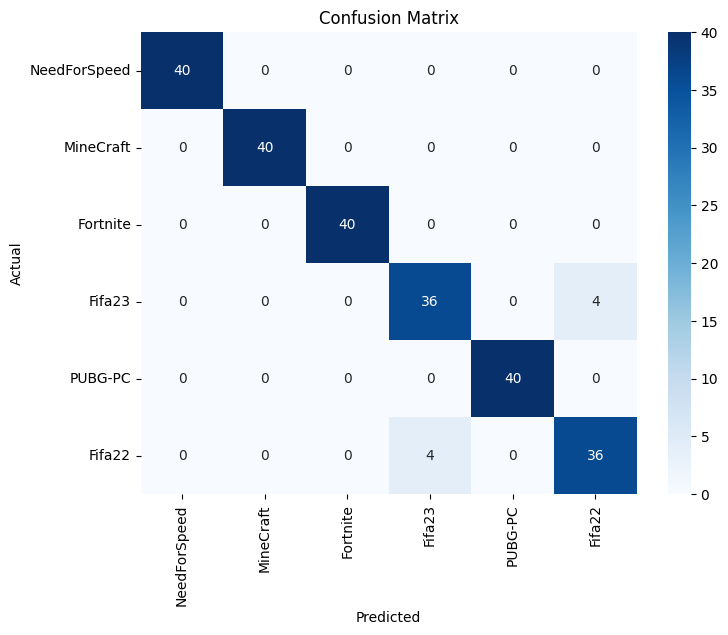

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {acc * 100:.2f}%")

# Print classification report
class_names = [label_to_name[i] for i in sorted(label_to_name)]
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Training KMeans...

✅ KMeans Accuracy: 81.67%

=== Classification Report ===
              precision    recall  f1-score   support

NeedForSpeed       1.00      1.00      1.00        40
   MineCraft       1.00      1.00      1.00        40
    Fortnite       1.00      1.00      1.00        40
      Fifa23       0.90      0.90      0.90        40
     PUBG-PC       1.00      1.00      1.00        40
      Fifa22       0.90      0.90      0.90        40

    accuracy                           0.97       240
   macro avg       0.97      0.97      0.97       240
weighted avg       0.97      0.97      0.97       240



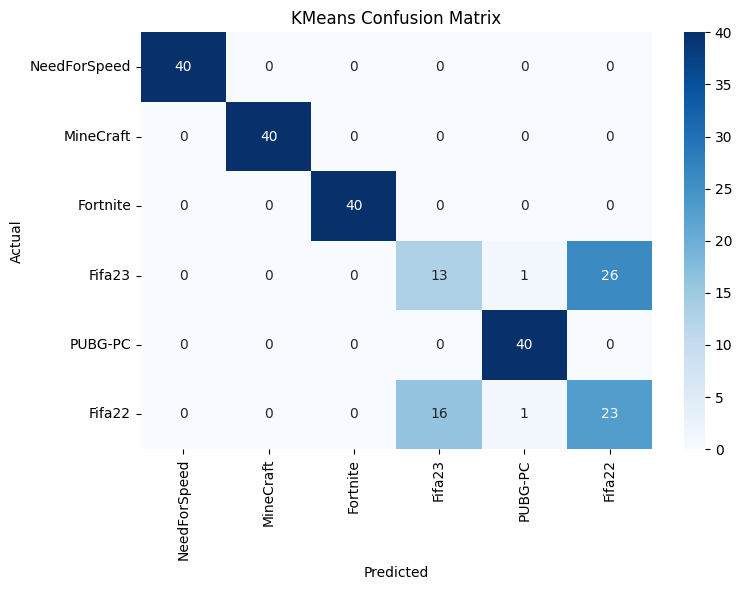

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# --- KMeans Model ---
print("\nTraining KMeans...")
num_classes = len(np.unique(y_train))
kmeans = KMeans(n_clusters=num_classes, random_state=42)
kmeans.fit(X_train)

# Predict test cluster labels
test_clusters = kmeans.predict(X_test)

# Map cluster -> most frequent label in train set
cluster_to_label = {}
train_clusters = kmeans.predict(X_train)
for cluster_id in range(num_classes):
    labels_in_cluster = y_train[train_clusters == cluster_id]
    if len(labels_in_cluster) == 0:
        continue
    most_common = np.bincount(labels_in_cluster).argmax()
    cluster_to_label[cluster_id] = most_common

# Convert cluster predictions to label predictions
kmeans_preds = [cluster_to_label[cluster] for cluster in test_clusters]

# --- Metrics ---
acc = accuracy_score(y_test, kmeans_preds)
print(f"\n✅ KMeans Accuracy: {acc * 100:.2f}%")

class_names = [label_to_name[i] for i in sorted(label_to_name)]
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, kmeans_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("KMeans Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [9]:
!pip install transformers torchvision scikit-learn opencv-python tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Extracting from: NeedForSpeed


NeedForSpeed: 100%|██████████████████████| 200/200 [00:00<00:00, 3177503.03it/s]


Extracting from: MineCraft


MineCraft: 100%|█████████████████████████| 200/200 [00:00<00:00, 3396197.57it/s]


Extracting from: Fortnite


Fortnite: 100%|██████████████████████████| 200/200 [00:00<00:00, 3396197.57it/s]


Extracting from: Fifa23


Fifa23: 100%|████████████████████████████| 200/200 [00:00<00:00, 1359579.90it/s]


Extracting from: PUBG-PC


PUBG-PC: 100%|███████████████████████████| 200/200 [00:00<00:00, 2943371.23it/s]


Extracting from: Fifa22


Fifa22: 100%|████████████████████████████| 200/200 [00:00<00:00, 3177503.03it/s]
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training...


Epoch 1/5: 100%|██████████████████████████████| 120/120 [03:52<00:00,  1.94s/it]


Epoch 1: Loss = 0.8023


Epoch 2/5: 100%|██████████████████████████████| 120/120 [03:44<00:00,  1.87s/it]


Epoch 2: Loss = 0.2116


Epoch 3/5: 100%|██████████████████████████████| 120/120 [04:24<00:00,  2.21s/it]


Epoch 3: Loss = 0.1323


Epoch 4/5: 100%|██████████████████████████████| 120/120 [04:27<00:00,  2.23s/it]


Epoch 4: Loss = 0.1005


Epoch 5/5: 100%|██████████████████████████████| 120/120 [03:58<00:00,  1.98s/it]


Epoch 5: Loss = 0.0739

Evaluating...

=== Classification Report ===
              precision    recall  f1-score   support

NeedForSpeed       1.00      1.00      1.00        40
   MineCraft       1.00      1.00      1.00        40
    Fortnite       1.00      1.00      1.00        40
      Fifa23       0.95      0.95      0.95        40
     PUBG-PC       1.00      1.00      1.00        40
      Fifa22       0.95      0.95      0.95        40

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



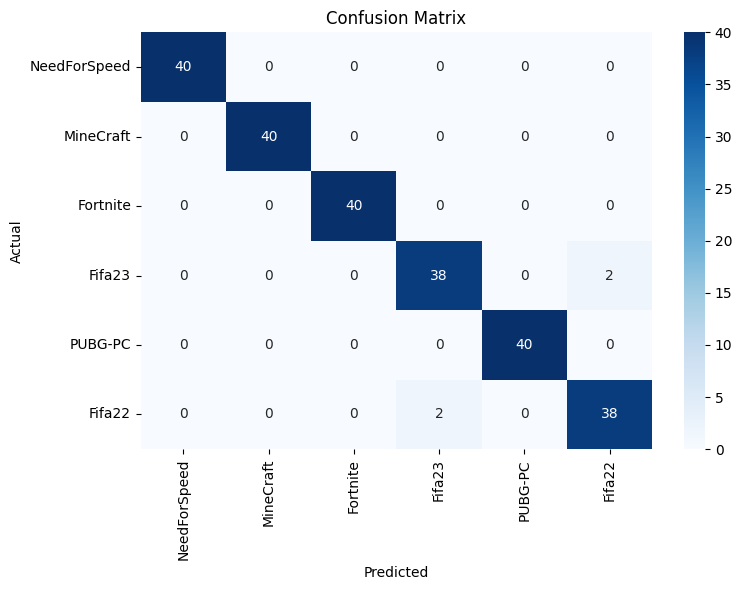

In [21]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor

# === Device Setup ===
device = "cuda" if torch.cuda.is_available() else "cpu"

# === Configuration ===
VIDEO_FOLDER = "/Users/raghavsomasundaram/Downloads/IP"  # <<<< CHANGE THIS PATH
MAX_FRAMES = 200
BATCH_SIZE = 8
EPOCHS = 5
LR = 3e-5
IMG_SIZE = 224

# === Dataset Class ===
class FrameDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(self.images[idx])
        label = self.labels[idx]
        return image, label

# === Frame Extraction ===
def extract_frames(video_path, interval_sec=1):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames, count = [], 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if int(count % (fps * interval_sec)) == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(rgb)
        count += 1
    cap.release()
    return frames

# === Load Data ===
def load_data(folder_path, max_frames_per_video=200):
    images, labels = [], []
    label_to_name, name_to_label = {}, {}
    label = 0

    for file in os.listdir(folder_path):
        if not file.endswith(".mp4"):
            continue
        game_name = os.path.splitext(file)[0]
        video_path = os.path.join(folder_path, file)
        print(f"Extracting from: {game_name}")
        frames = extract_frames(video_path)

        for frame in tqdm(frames[:max_frames_per_video], desc=game_name):
            images.append(frame)
            labels.append(label)

        label_to_name[label] = game_name
        name_to_label[game_name] = label
        label += 1

    return images, labels, label_to_name

# === Main Execution ===
if __name__ == "__main__":
    # Load and prepare data
    images, labels, label_to_name = load_data(VIDEO_FOLDER, MAX_FRAMES)
    num_classes = len(label_to_name)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=0.2, stratify=labels, random_state=42
    )

    # Transformations using ViTFeatureExtractor
    feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
    ])

    # Datasets and Dataloaders
    train_dataset = FrameDataset(X_train, y_train, transform)
    test_dataset = FrameDataset(X_test, y_test, transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    # Load Pretrained ViT Model
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=num_classes
    ).to(device)

    # Optimizer and Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = torch.nn.CrossEntropyLoss()

    # === Training Loop ===
    print("\nTraining...")
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")

    # === Evaluation ===
    print("\nEvaluating...")
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(pixel_values=images)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # Classification Report
    class_names = [label_to_name[i] for i in sorted(label_to_name)]
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()



✅ Vision Transformer Accuracy: 98.33%

=== Classification Report ===
              precision    recall  f1-score   support

NeedForSpeed       1.00      1.00      1.00        40
   MineCraft       1.00      1.00      1.00        40
    Fortnite       1.00      1.00      1.00        40
      Fifa23       0.95      0.95      0.95        40
     PUBG-PC       1.00      1.00      1.00        40
      Fifa22       0.95      0.95      0.95        40

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



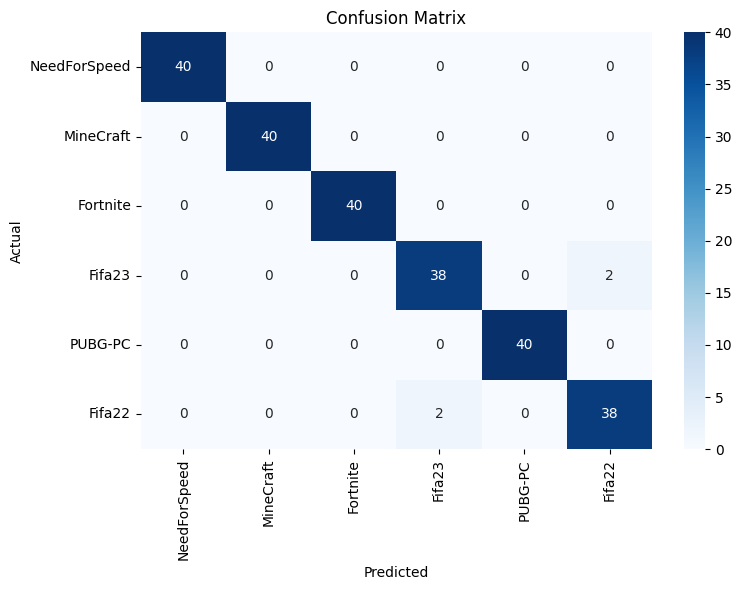

In [22]:

def evaluations():
    acc = accuracy_score(y_test, all_preds)
    print(f"\n✅ Vision Transformer Accuracy: {acc * 100:.2f}%")
# Classification Report
    class_names = [label_to_name[i] for i in sorted(label_to_name)]
    print("\n=== Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

evaluations()

Extracting from: NeedForSpeed


NeedForSpeed: 100%|█████████████████████████| 20/20 [00:00<00:00, 514638.53it/s]


Extracting from: MineCraft


MineCraft: 100%|████████████████████████████| 20/20 [00:00<00:00, 693273.39it/s]


Extracting from: Fortnite


Fortnite: 100%|█████████████████████████████| 20/20 [00:00<00:00, 621378.37it/s]


Extracting from: Fifa23


Fifa23: 100%|███████████████████████████████| 20/20 [00:00<00:00, 527585.41it/s]


Extracting from: PUBG-PC


PUBG-PC: 100%|██████████████████████████████| 20/20 [00:00<00:00, 476625.45it/s]


Extracting from: Fifa22


Extracting embeddings: 100%|████████████████████| 15/15 [00:03<00:00,  4.36it/s]



Clustering using KMeans...

KNN Classification...

=== Classification Report ===
              precision    recall  f1-score   support

NeedForSpeed       1.00      1.00      1.00         4
   MineCraft       1.00      0.75      0.86         4
    Fortnite       1.00      1.00      1.00         4
      Fifa23       0.60      0.75      0.67         4
     PUBG-PC       1.00      1.00      1.00         4
      Fifa22       0.75      0.75      0.75         4

    accuracy                           0.88        24
   macro avg       0.89      0.88      0.88        24
weighted avg       0.89      0.88      0.88        24


✅ KMeans + KNN Accuracy: 87.50%


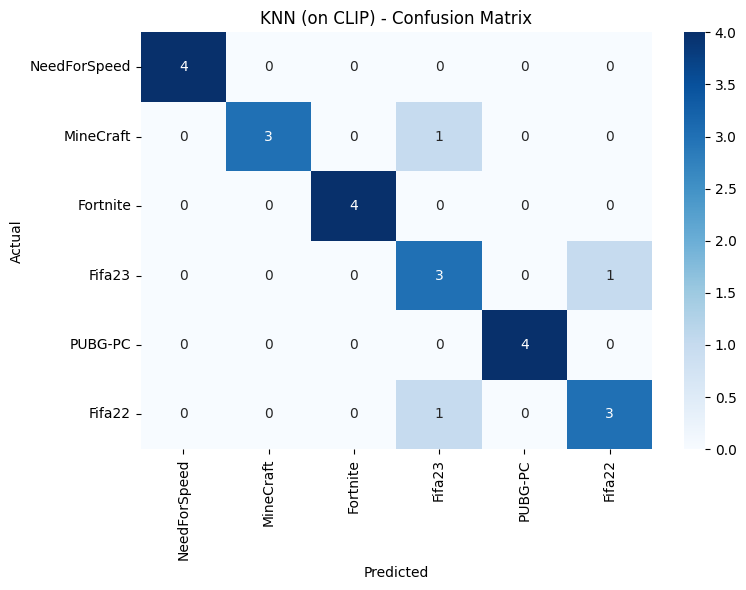

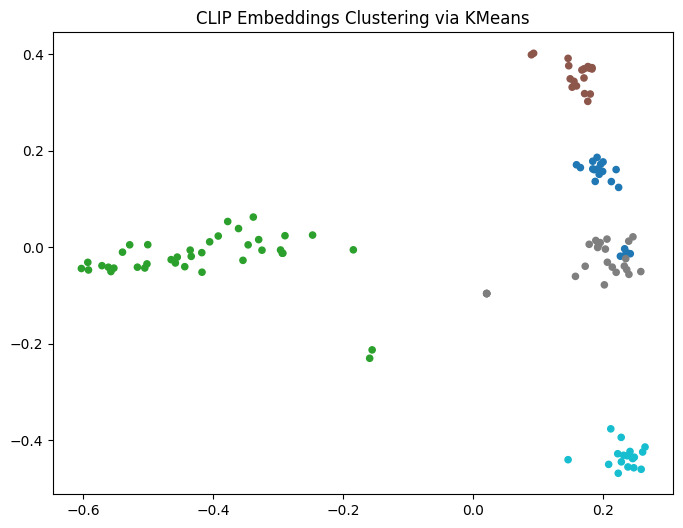

In [14]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from transformers import CLIPProcessor, CLIPModel

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
VIDEO_FOLDER = "/Users/raghavsomasundaram/Downloads/IP"  # CHANGE THIS
MAX_FRAMES = 20
IMG_SIZE = 224
N_CLUSTERS = 5
KNN_K = 5

# === CLIP Model ===
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# === Frame Extraction ===
def extract_frames(video_path, interval_sec=1):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames, count = [], 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if int(count % (fps * interval_sec)) == 0:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(rgb))
        count += 1
    cap.release()
    return frames

# === Load Data ===
def load_data(folder_path, max_frames_per_video=20):
    images, labels = [], []
    label_to_name, name_to_label = {}, {}
    label = 0

    for file in os.listdir(folder_path):
        if not file.endswith(".mp4"):
            continue
        game_name = os.path.splitext(file)[0]
        video_path = os.path.join(folder_path, file)
        print(f"Extracting from: {game_name}")
        frames = extract_frames(video_path)

        for frame in tqdm(frames[:max_frames_per_video], desc=game_name):
            images.append(frame)
            labels.append(label)

        label_to_name[label] = game_name
        name_to_label[game_name] = label
        label += 1

    return images, labels, label_to_name

# === Feature Extraction using CLIP ===
def get_clip_embeddings(images):
    all_embeddings = []
    for i in tqdm(range(0, len(images), 8), desc="Extracting embeddings"):
        batch = images[i:i+8]
        inputs = clip_processor(images=batch, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            embeddings = clip_model.get_image_features(**inputs)
            embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)
        all_embeddings.append(embeddings.cpu().numpy())
    return np.vstack(all_embeddings)

# === Main ===
if __name__ == "__main__":
    images, labels, label_to_name = load_data(VIDEO_FOLDER, MAX_FRAMES)
    embeddings = get_clip_embeddings(images)

    # === KMeans Clustering (unsupervised grouping) ===
    print("\nClustering using KMeans...")
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    cluster_ids = kmeans.fit_predict(embeddings)

    # === KNN Classification ===
    print("\nKNN Classification...")
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, stratify=labels, random_state=42
    )
    knn = KNeighborsClassifier(n_neighbors=KNN_K)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_test)

    class_names = [label_to_name[i] for i in sorted(label_to_name)]
    print("\n=== Classification Report ===")
    print(classification_report(y_test, preds, target_names=class_names))
    acc = accuracy_score(y_test, preds)
    print(f"\n✅ KMeans + KNN Accuracy: {acc * 100:.2f}%")

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title("KNN (on CLIP) - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Optional: Visualize Clusters
    try:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(embeddings)
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_ids, cmap='tab10', s=20)
        plt.title("CLIP Embeddings Clustering via KMeans")
        plt.show()
    except:
        print("Install sklearn's PCA and matplotlib to visualize clusters.")
